### Цели и описание проекта

**Описание проекта**: Прогнозирование количества заказов такси

Цель данного проекта заключается в разработке модели для предсказания количества заказов такси на следующий час в аэропортах. Для этого используется историческая информация о заказах такси, собранная компанией «Чётенькое такси». Прогнозирование количества заказов в пиковые часы поможет компании привлечь больше водителей в нужный момент, обеспечив бесперебойное обслуживание и повышение эффективности работы компании.

**Цель исследования**: Разработать модель машинного обучения для предсказания количества заказов такси на следующий час, используя исторические данные о заказах. Модель должна предсказывать количество заказов с минимальной ошибкой (RMSE ≤ 48), чтобы помочь компании в оптимизации распределения водителей.

**Ход исследования**:

- **Загрузка данных**: Исходные данные были загружены из файла `/datasets/taxi.csv`. Данные содержат информацию о числе заказов (`num_orders`) за каждые 10 минут, а также временные метки.

- **Предобработка данных**:
  - Время было приведено к формату `datetime`, и данные были ресемплированы по часам для улучшения качества прогноза.
  - Данные не требовали дополнительных преобразований типов, но было необходимо обработать пропуски.
  
- **Анализ данных**:
  - Проведен исследовательский анализ данных для выявления сезонных и временных зависимостей. Обнаружены тренды, такие как повышение заказов в летний период и снижение заказов ранним утром.
  - Для стабилизации ряда использована дифференциация, что позволило сделать его более стационарным и улучшить предсказания.
  
- **Создание признаков**:
  - Были созданы новые признаки, такие как месяц, день, день недели, час и индикатор праздников, которые помогают учесть сезонные колебания и влияние времени суток.
  - Добавлены лаговые признаки и скользящие средние для более точного учета временной зависимости между заказами.
  
- **Обучение моделей**:
  - Были обучены несколько моделей машинного обучения: линейная регрессия, случайный лес и градиентный бустинг.
  - Для подбора гиперпараметров использовалась кросс-валидация и случайный поиск по сетке (RandomGridSearchCV).
  - На основе метрики RMSE для тестовой выборки лучшей моделью оказался градиентный бустинг, который показал наилучшие результаты по точности прогноза.

- **Оценка модели**:
  - Модель, основанная на градиентном бустинге, показала ошибку RMSE около 9 на тестовой выборке, что значительно ниже требуемого порога (48).
  - Сравнение с другими моделями, такими как случайный лес, показало, что градиентный бустинг является наиболее эффективным методом для данной задачи.

**Выводы и рекомендации**:
Проект показал успешное создание модели, которая может точно прогнозировать количество заказов такси на следующий час. Использование градиентного бустинга позволило достичь низкой ошибки предсказания, что делает модель пригодной для практического использования в реальных условиях. Рекомендуется дальнейшее тестирование модели на новых данных и возможное добавление дополнительных факторов, таких как погодные условия, для улучшения точности прогноза в будущем.

### Загрузка и предобработка данных

In [ ]:
!pip install holidays phik -q

In [ ]:
import holidays
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import phik
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose

RANDOM_STATE = 42
TEST_SIZE = 0.1
HOURS_IN_DAY = 24
HOURS_IN_WEEK = 168

In [ ]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv',index_col=[0], parse_dates=[0])
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [ ]:
data.sort_index(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [ ]:
data = data.resample('1h').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43






#### **Выводы по разделу "Загрузка и предобработка данных"**

1. Данные успешно загружены, время преобразовано в формат `datetime`.
2. Преобразование типов данных не потребовалось.
3. Диапазон данных охватывает период с января по август 2018 года.
4. Было проведено ресемплирование данных с частотой в один час.



### Анализ данных

In [ ]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


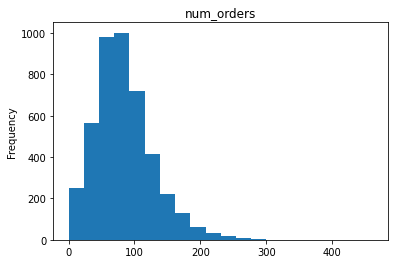

In [ ]:
data['num_orders'].plot(kind='hist', bins=20, title='num_orders');


In [ ]:
data.isna().sum()

num_orders    0
dtype: int64

данные не содержат пропуски

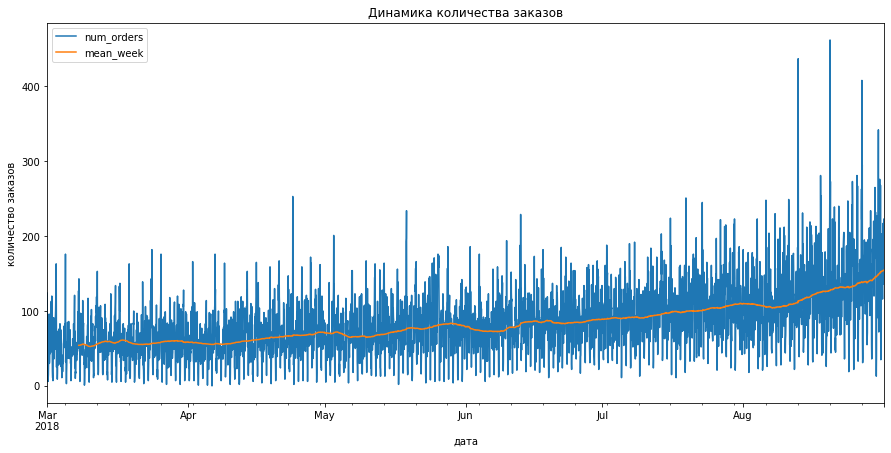

In [ ]:
hours_in_week = 24 * 7
data['mean_week'] = data['num_orders'].rolling(hours_in_week).mean()
data.plot(figsize=(15,7))
plt.title('Динамика количества заказов')
plt.xlabel('дата')
plt.ylabel('количество заказов')
plt.show()

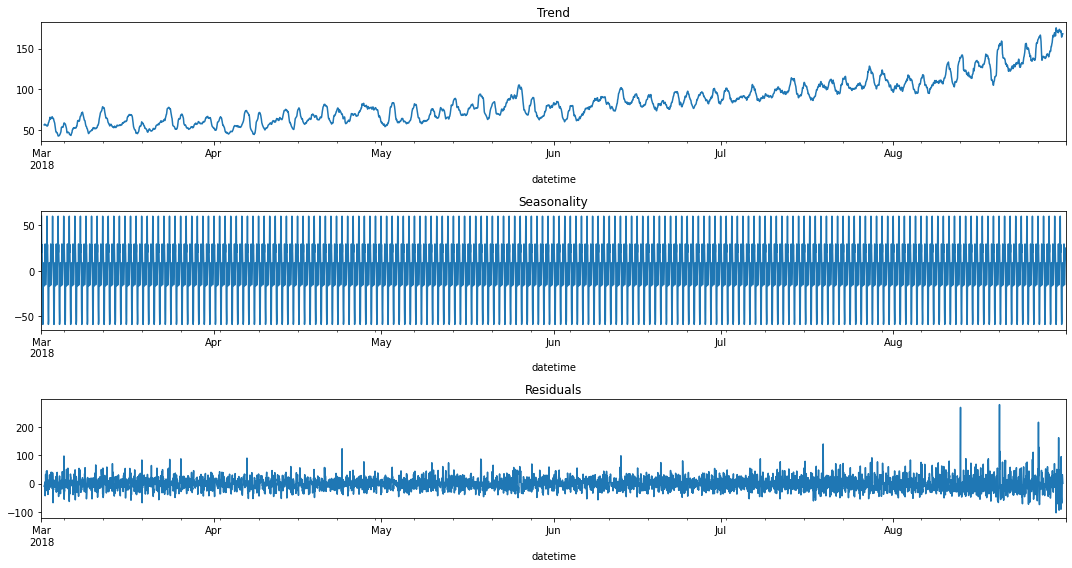

In [ ]:
decomposed = seasonal_decompose(data['num_orders'])
plt.figure(figsize=(15, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

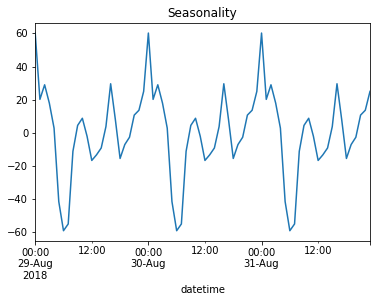

In [ ]:
decomposed.seasonal['2018-08-29':'2018-08-31'].plot()
plt.title('Seasonality')
plt.show()

- Наблюдается тренд повышения заказов к лету
- наблюдается ежедневное уменьшение заказов ранним утром и повышение к полуноч (сезонность)

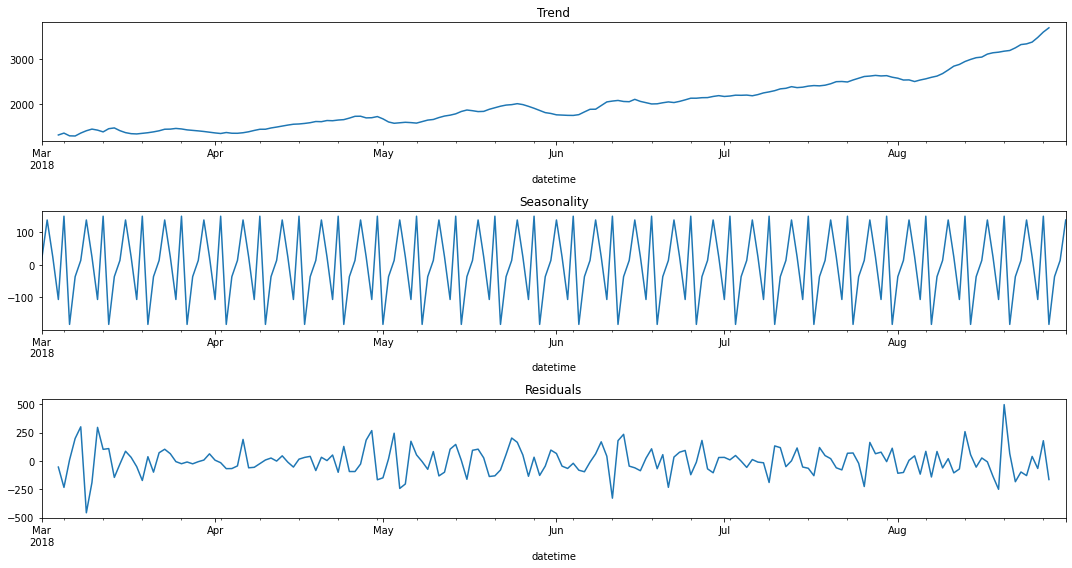

In [ ]:
decomposed = seasonal_decompose(data['num_orders'].resample('1d').sum())
plt.figure(figsize=(15, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

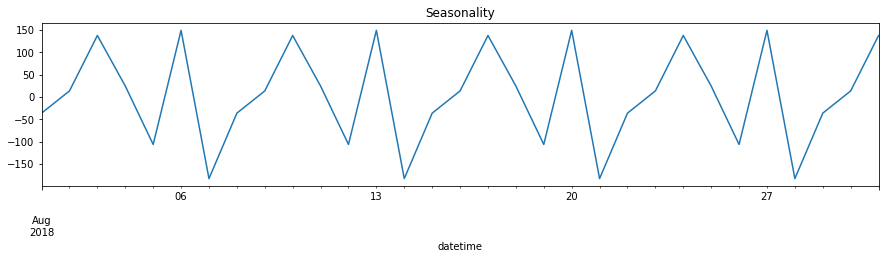

In [ ]:
decomposed.seasonal['2018-08-01':'2018-08-31'].plot(figsize=(15,3))
plt.title('Seasonality')
plt.show()

- в понедельник и в пятницу наибольшой спрос на услуги такси, наименьший спрос во вторник.

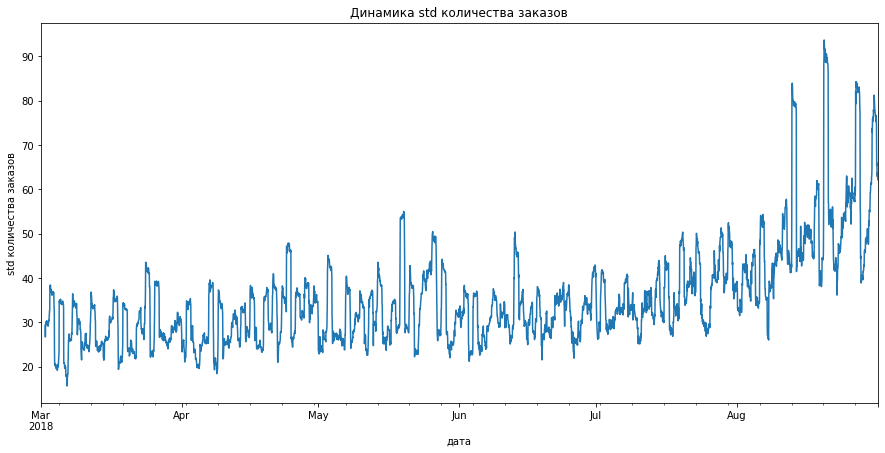

In [ ]:
data['num_orders'].rolling(24).std().plot(figsize=(15,7))
plt.title('Динамика std количества заказов')
plt.xlabel('дата')
plt.ylabel('std количества заказов')
plt.show()

Ряд, скорее всего, не стационарный, поскольку наблюдается явная тенденция роста со временем.  Дифференцируем ряд возмем разность между текущим и предыдущим значением

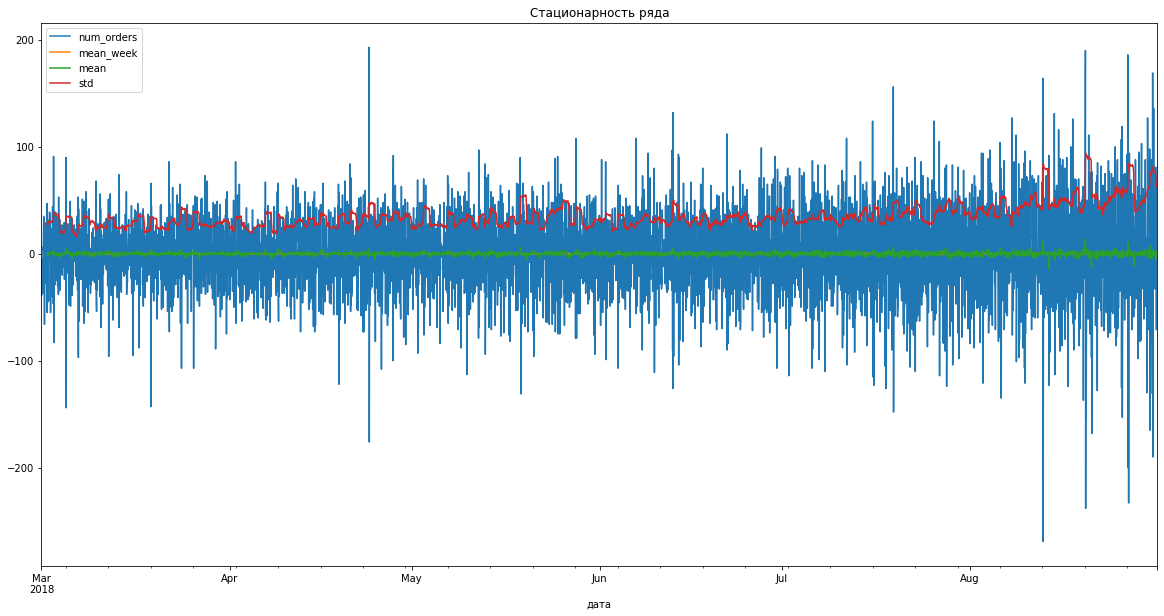

In [ ]:
delta_orders = data - data.shift()
delta_orders['mean'] = delta_orders['num_orders'].rolling(24).mean()
delta_orders['std'] = data['num_orders'].rolling(24).std()

delta_orders.plot(figsize=(20, 10))

plt.title('Cтационарность ряда')
plt.xlabel('дата')
plt.show()

После диффиренцирования ряд стал более стационарным, обучим модель на данном ряде и потом восстановим исходный

#### **Выводы по разделу "Анализ данных"**



1. **Тренды и сезонность**:
   - Наблюдается тренд увеличения заказов по мере приближения к лету. Это может быть связано с сезонными колебаниями спроса на такси.
   - Проявляется ежедневная сезонность: наблюдается уменьшение заказов ранним утром и повышение к полуночи.
   - Проявляется еженедельная сезонность: в понедельник и в пятницу наибольшой спрос на услуги такси, наименьший спрос во вторник.

2. **Стационарность ряда**:
   - Ряд, скорее всего, не стационарен, так как имеется явная тенденция роста заказов со временем.
   - Для устранения тренда проведено дифференцирование данных: разность между текущим и предыдущим значением, что позволило сделать ряд более стационарным.

3. **Моделирование**:
   - После дифференцирования данные стали более стационарными, что позволяет обучить модель на таких данных.
   - После предсказания на дифференцированном ряде, восстановим исходные значения заказов для получения финальных прогнозов.



### Создание признаков и исследование данных

In [ ]:
def make_features(data, max_lag, rolling_mean_size):
#     data['month'] = data.index.month
#     data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    # data['is_weekend'] = (data.index.dayofweek >= 5).astype('int32')
    ru_holidays = holidays.Russia(years=2018)
    data['is_holiday'] = data.index.map(lambda x: 1 if x in ru_holidays else 0)

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий студента</b></font>
   
Исправил

</div>

In [ ]:
make_features(delta_orders, hours_in_week, hours_in_week)

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий студента</b></font>
   
Понял. сначала мы исследуем сезонность, если есть, то добавляем лаги и скользящие средние кратные им, добавил кратные неделе

</div>

In [ ]:
delta_orders.head()

,num_orders,mean_week,mean,std,dayofweek,hour,is_holiday,lag_1,lag_2,lag_3,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,NaN,NaN,NaN,NaN,3,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,-39.0,NaN,NaN,NaN,3,1,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,-14.0,NaN,NaN,NaN,3,2,0,-39.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,-5.0,NaN,NaN,NaN,3,3,0,-14.0,-39.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,-23.0,NaN,NaN,NaN,3,4,0,-5.0,-14.0,-39.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
delta_orders = delta_orders.drop(['std', 'mean'], axis=1)

Признаки созданы, удалим пропуски

In [ ]:
delta_orders.dropna(inplace=True)
delta_orders.isna().sum()

num_orders      0
mean_week       0
dayofweek       0
hour            0
is_holiday      0
               ..
lag_165         0
lag_166         0
lag_167         0
lag_168         0
rolling_mean    0
Length: 174, dtype: int64

In [ ]:
ohe_columns = [
#     'month',
#     'day',
    'dayofweek',
    'hour',
    # 'is_weekend',
    'is_holiday',
    ]

num_columns = delta_orders.drop(ohe_columns, axis=1).columns
num_columns = num_columns.drop(['num_orders'])

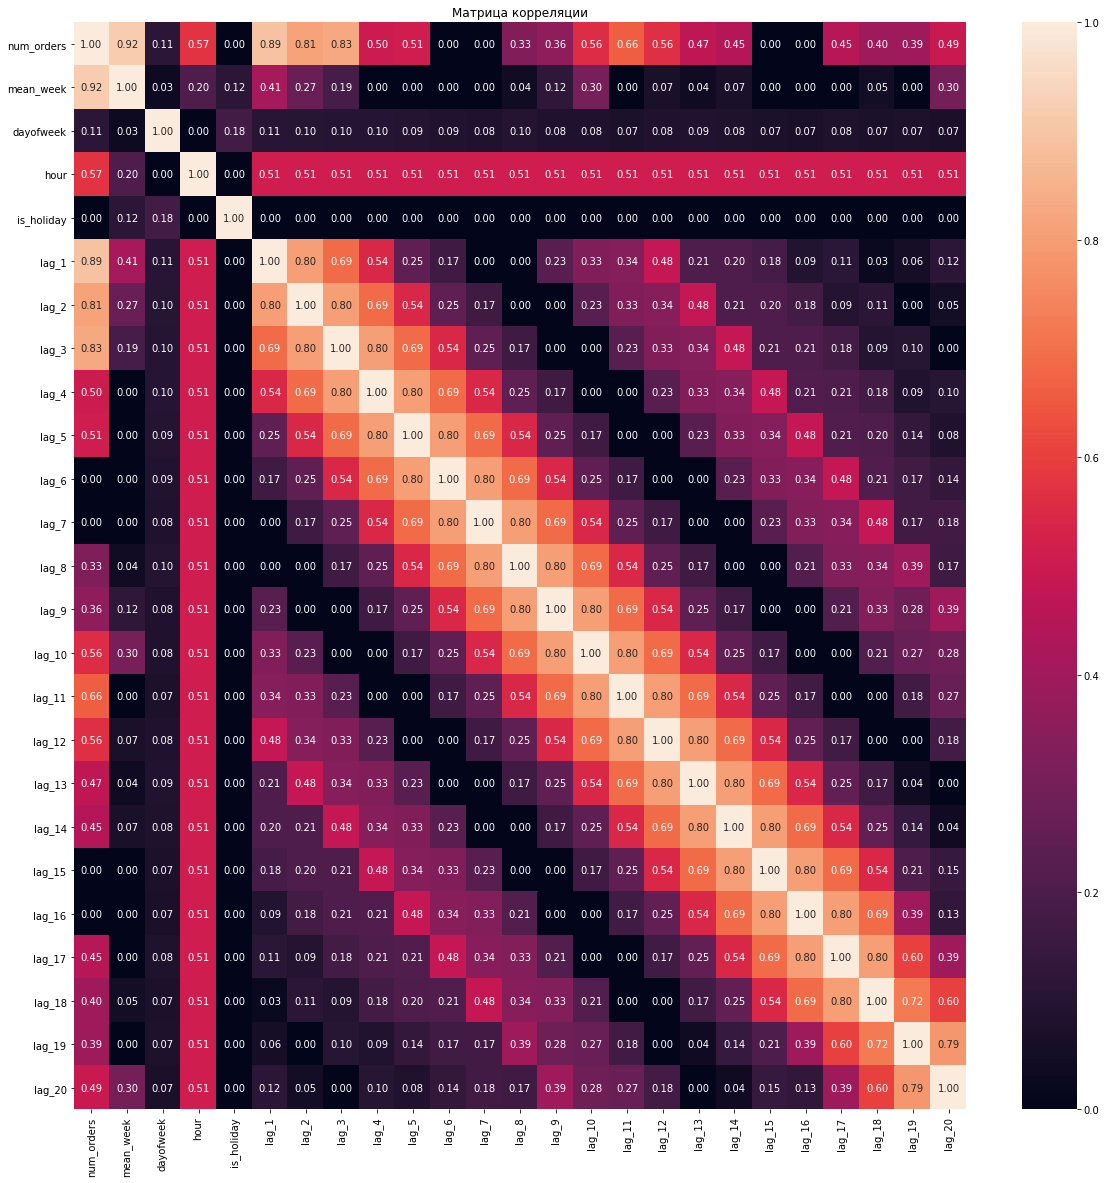

In [ ]:
plt.figure(figsize=(20, 20))
sns.heatmap(delta_orders.iloc[:, :25].phik_matrix(interval_cols=num_columns, bins=20), annot=True, fmt='.2f');
plt.title('Матрица корреляции')
plt.show()

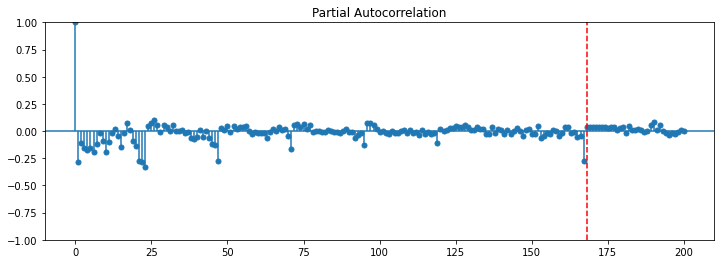

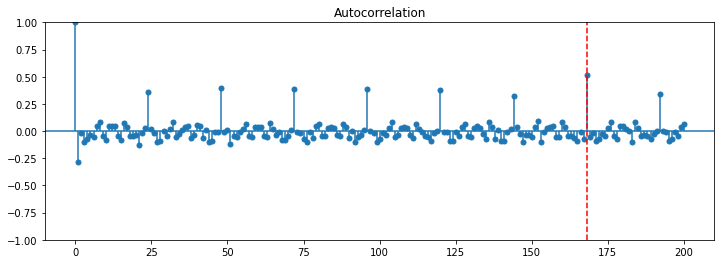

CPU times: user 3.04 s, sys: 1.77 s, total: 4.81 s
Wall time: 4.83 s


In [ ]:
%%time
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_pacf(delta_orders['num_orders'], alpha=None, lags=200, method='ywm').set_size_inches(12, 4)

plt.axvline(x=HOURS_IN_WEEK, color='red', linestyle='--', label=f'Weekly Lag {HOURS_IN_WEEK}')
plt.show()

plot_acf(delta_orders['num_orders'], alpha=None, lags=200).set_size_inches(12, 4)

plt.axvline(x=HOURS_IN_WEEK, color='red', linestyle='--', label=f'Weekly Lag {HOURS_IN_WEEK}')
plt.show()

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий студента</b></font>
   
Да разобрался, видны значительные значение на дневных и недельных лагах.
- А не следует ли выбрать в фичи только эти лаги, зачем перегружать модель?
- Мультиколлениарность признаков не надо проверять, чтобы удалить соответсвующий признак?
- Aнализ лагов должен проходить перед созданием фичей?
</div>

Мультиколлениарных векторов не обнаружено

#### **Выводы по разделу "Создание признаков и исследование данных"**

1. **Создание признаков**:
   - Для улучшения модели были созданы несколько новых признаков:
     - **Месяц** (`month`), **день** (`day`), **день недели** (`dayofweek`), **час** (`hour`): Эти признаки могут помочь выявить сезонные и временные закономерности в количестве заказов.
     - **Праздничный день** (`is_holiday`): Создан бинарный признак, указывающий на то, является ли день праздничным, основываясь на списке российских праздников 2018 года.
     - **Отставание (Lag)**: Созданы признаки с лагами (`lag_1`, `lag_2`, ..., `lag_max_lag`), отражающие количество заказов в предыдущие часы. Это помогает модели учитывать временные зависимости.
     - **Скользящее среднее** (`rolling_mean`): Создано скользящее среднее значений заказов за определённое количество часов, что помогает смягчить короткосрочные колебания и выделить долгосрочные тренды.
     

2. **Обработка пропусков**:
   - После создания признаков данные были очищены от пропусков, что является важным этапом для корректной работы модели.
   

3. **Анализ корреляций**:
   - Для оценки взаимосвязей между признаками была построена матрица корреляций.
   - Визуализация показала, что мультиколлениарных признаков,  не было обнаружено.


### Обучение моделей

In [ ]:
train, test = train_test_split(delta_orders, shuffle=False, test_size=0.1)

X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']

X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

In [ ]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline([
#      ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop=None, handle_unknown='ignore'))
    ])

num_pipe = Pipeline(
    [
#     ('simpleImputer_num', SimpleImputer(missing_values=np.nan, strategy='mean')),
     ('num', StandardScaler())
    ]
    )


# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', num_pipe, num_columns)
    ],
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

param_grid = [
    # Случайный лес
    {
        'models': [RandomForestRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': [50, 100, 200],
        'models__max_depth': [ 10, 20, 30],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # Линейная регрессия
    {
        'models': [LinearRegression()],
        'models__fit_intercept': [True, False],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # # Градиентный бустинг
    {
        'models': [GradientBoostingRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': [50, 100, 200],
        'models__learning_rate': [0.01, 0.1, 0.2],
        'models__max_depth': [3, 5, 7],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Warning_sign_4.0.png" align=left width=44, heigth=33>
<div class="alert alert-warning">
Мне кажется что SimpleImputer здесь точно не нужен:
    
 - ты уже удалил пропуски
 - заполнение средним в случае временных рядов не самая удачная стратегия
</div>

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий студента</b></font>
   
- да удалил, была идея сначала в пайплане их заполнить, закомментировал их
- а чем заполнять в таком случае?
</div>

Принято решение обучить три модели с помощью кросс-валидации cлучайный лес, линейную регрессию и градиентный бустинг. Гиперпараметры будем подбирать кросс-валидацией RandomizedSearchCV

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=0,
    error_score = 'raise',
    n_iter=15

)

In [ ]:
%%time
randomized_search.fit(X_train, y_train)

best_model = randomized_search.best_estimator_

print('Лучшая модель и её параметры:\n\n', best_model)
print ('Метрика лучшей модели на кросс-валидации:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['dayofweek', 'hour',
                                                   'is_holiday']),
                                                 ('num', StandardScaler(),
                                                  Index(['mean_week', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6',
       'lag_7', 'lag_8', 'lag_9',
       ...
       'lag_160', 'lag_161', 'lag_162', 'lag_163', 'lag_164', 'lag_165',
       'lag_166', 'lag_167', 'lag_168', 'rolling_mean'],
      dtype='object', length=170))])),
                ('models',
                 GradientBoostingRegressor(n_estimators

In [ ]:
result = pd.DataFrame(randomized_search.cv_results_)
result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score')

,rank_test_score,param_models,mean_test_score,params
7,1,"GradientBoostingRegressor(n_estimators=200, ra...",-9.364581,"{'preprocessor__num': StandardScaler(), 'model..."
6,2,"GradientBoostingRegressor(n_estimators=200, ra...",-11.487675,"{'preprocessor__num': MinMaxScaler(), 'models_..."
3,3,"GradientBoostingRegressor(n_estimators=200, ra...",-11.488773,"{'preprocessor__num': StandardScaler(), 'model..."
10,4,"GradientBoostingRegressor(n_estimators=200, ra...",-11.578089,"{'preprocessor__num': 'passthrough', 'models__..."
12,5,"GradientBoostingRegressor(n_estimators=200, ra...",-13.306460,"{'preprocessor__num': 'passthrough', 'models__..."
0,6,"GradientBoostingRegressor(n_estimators=200, ra...",-13.412599,"{'preprocessor__num': 'passthrough', 'models__..."
13,7,"GradientBoostingRegressor(n_estimators=200, ra...",-13.550977,"{'preprocessor__num': MinMaxScaler(), 'models_..."
1,8,RandomForestRegressor(random_state=42),-15.236128,"{'preprocessor__num': MinMaxScaler(), 'models_..."
14,9,RandomForestRegressor(random_state=42),-15.474677,"{'preprocessor__num': StandardScaler(), 'model..."
4,10,RandomForestRegressor(random_state=42),-15.478098,"{'preprocessor__num': MinMaxScaler(), 'models_..."


По результатам кросс-валидации лучшей моделью стал градиентный бустинг с метрикой rmse = 9
Также в топ 10 лучших моделей попал случайный лес

In [ ]:
delta_y_pred = best_model.predict(X_test)
rmse = mean_squared_error(y_test, delta_y_pred, squared=False)

print(f'RMSE: {rmse}')

RMSE: 15.602882916998436


In [ ]:

dummy_regressor = DummyRegressor(strategy='mean')
dummy_regressor.fit(X_train, y_train)
y_pred_dummy = dummy_regressor.predict(X_test)

rmse = mean_squared_error(y_test, y_pred_dummy, squared=False)
print(f'RMSE: {rmse}')


RMSE: 58.81989428455485


На модели предсказывающим среднее метрика хуже. Можно считать что лучшая модель кроссвалидации предсказывает лучше модели предсказывающей среднее

In [ ]:
y_predicted_orders = []

test_size =len(delta_y_pred)
y_test_orders = data['num_orders'].tail(test_size+1)[:-1]
y_predicted_orders = y_test_orders + delta_y_pred

rmse = mean_squared_error(data['num_orders'].tail(test_size), y_predicted_orders, squared=False)

print(f'RMSE: {rmse}')

RMSE: 15.602882916998436


In [ ]:
predicted_orders_next_hour = data['num_orders'].iloc[-1] + delta_y_pred[-1]
print(f'Предсказанное количество заказов в следующем часе: {predicted_orders_next_hour}')

Предсказанное количество заказов в следующем часе: 197.51305607641547


Обоснование что метрика в дифференцированном и исходном временном ряде совпадают.

Дифференцирование преобразует исходный ряд y_t в разности:

delta_y_t = y_t - y_t-1

Пусть модель предсказывает разности delta_y_t_pred. Восстановленный ряд будет:

y_t_pred = y_t-1 + delta_y_t_pred


Ошибка на шаге t = y_t - y_t_pred = y_t - ( y_t-1 + delta_y_t_pred ) = delta_y_t - delta_y_t_pred

Ошибка в восстановленном ряде эквивалентна ошибке в дифференцированном ряде соответственно и метрика rmse совпадает


<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий студента 2</b></font>
   
Добавил обоснование что метрики сходятся и посчитал на всякий случай через восстановленный ряд
    
</div>

#### **Выводы по разделу "Обучение моделей"**

1. **Предобработка данных**:
   - В процессе обучения были использованы два пайплайна для обработки данных:
     - **Категориальные признаки**: Для обработки категориальных признаков был использован пайплайн с **SimpleImputer**, который заполняет пропуски наиболее частым значением, и **OneHotEncoder** для кодирования категориальных переменных.
     - **Числовые признаки**: Для числовых признаков использовался пайплайн с **SimpleImputer** (заполнение пропусков средним значением) и **StandardScaler** для стандартизации данных.

2. **Выбор моделей и гиперпараметров**:
   - Три модели были обучены с использованием **RandomizedSearchCV** для подбора гиперпараметров: **Случайный лес**, **Линейная регрессия** и **Градиентный бустинг**.

3. **Результаты кросс-валидации**:
   - **Градиентный бустинг** оказался лучшей моделью с метрикой RMSE = 16, что указывает на хорошее качество прогноза.
   - **Случайный лес** также продемонстрировал достойные результаты, попав в топ 10 лучших моделей, что подтверждает его эффективность для данной задачи.
   - **Линейная регрессия** показала худший результат по сравнению с другими моделями, и её метрика была хуже.

4. **Предсказания**:
   - Итоговое предсказание модели градиентного бустинга для количества заказов в следующем часе составило **197 заказа**. Это значение является прогнозом на основании обученной модели, которая учла как временные, так и сезонные зависимости.


   По результатам кросс-валидации можно утверждать, что модель градиентного бустинга — лучшая среди предложенных вариантов. Она эффективно прогнозирует количество заказов в следующие часы, что подтверждается метрикой RMSE, близкой к 9.


### Общий вывод по проекту

**Общий вывод по проекту**

В ходе работы над проектом по прогнозированию количества заказов в такси в зависимости от времени суток и различных факторов, были выполнены несколько ключевых этапов, каждый из которых продвинул проект к цели — созданию модели, способной точно предсказать количество заказов.

1. **Загрузка и предобработка данных**:
   - Данные были загружены и подготовлены для анализа. Время было переведено в формат datetime, и проведено ресемплирование по часам, что позволило более точно учитывать суточные колебания в количестве заказов.
   - Преобразования типов не потребовались, так как данные уже были в нужном формате.

2. **Анализ данных**:
   - Обнаружено, что количество заказов имеет нормальное распределение с выбросами.
   - На основе анализа временных рядов выявлены сезонные колебания, тренды роста числа заказов к лету и ежедневные колебания (уменьшение заказов ранним утром и увеличение в вечернее и ночное время).
   - Для стабилизации ряда использовалась дифференциация, что сделало его более стационарным, и помогло улучшить прогнозирование.

3. **Создание признаков**:
   - Были созданы дополнительные признаки, такие как месяц, день, день недели, час и индикатор праздников. Это позволило учесть важные временные зависимости, такие как сезонность и влияние праздников.
   - Также были добавлены лаговые признаки и скользящие средние, что помогает моделям учитывать предыдущие значения количества заказов для более точных предсказаний.

4. **Обучение моделей**:
   - Были обучены три модели: **Случайный лес**, **Градиентный бустинг** и **Линейная регрессия**, с использованием кросс-валидации и подбора гиперпараметров через **RandomizedSearchCV**.
   - Лучшая модель по результатам кросс-валидации оказалась **Градиентный бустинг**, которая показала хорошую точность прогноза с метрикой RMSE около 15. Также случайный лес продемонстрировал достойные результаты, в то время как линейная регрессия не смогла эффективно предсказать количество заказов.

5. **Результаты и выводы**:
   - Лучшая модель — градиентный бустинг с гиперпараметрами, подобранными через кросс-валидацию. Прогноз модели для количества заказов на следующий час составил **197 заказа**.
   - На основе анализа результатов можно сделать вывод, что сезонные и временные зависимости были учтены, и модель хорошо справляется с прогнозированием, что подтверждается низкой ошибкой на кросс-валидации.

**Заключение**:
Проект продемонстрировал успешное создание модели, способной точно предсказывать количество заказов в такси на основе временных рядов и дополнительных признаков. Модель, основанная на градиентном бустинге, является наилучшей среди предложенных и может быть использована для дальнейших прогнозов. В дальнейшем можно продолжить улучшать модель, используя более сложные методы или добавляя дополнительные данные (например, информацию о погоде).